In [1]:
#importy niezbędne do włączenia działającej aplikacji wizualizacji działania diagramów Voronoi
import numpy as np
from Fortune_algorithm import FortuneAlgorithm
from Metric import euclidean_2d
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import json as js
import random
from typing import List
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = False)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = False)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()

In [3]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()


In [4]:
#funkcje pomocnicze do generowania punktów
import math

#generuje punkty z zadanego kwadratu, rozmieszczone losowo z rozkładu jednostajnego
#liczbe wygenerowanych punktów przekazuje się poprzez number_of_points
#wspołrzędna lewego dolnego wierzchołka kwadratu która jest postaci (lower_left, lower_left)
#ustalamy przez parametr lower_left
#analogicznie działa upper_right
def uniformly_distributed_points(number_of_points = 25, lower_left = 0, upper_right = 2):
    return np.array([np.random.uniform(lower_left, upper_right, size=(2,)) for _ in range(number_of_points)])

#współrzędne kartowe (o wartościach całkowitych)
#parametr upper_right decyduje o tym jaki wymiar będzie mieć kwadrat współrzędnych kratowych
#ma on wymiary lewy dolny wierzchołek postaci (0,0) i prawy górny postaci (upper_right_upper_right)
#epsilon oznacza poziom zaszumienia współrzędnej y, żeby nie miały dokładnie tej samej wartości
def grid_coordinates(upper_right = 4, epsilon = 1e-5):
    return np.array([(i, j+np.random.uniform(0, epsilon)) for i in range(upper_right) for j in range(upper_right)])

#punkty rozłożone równomiernie ze względu na kąt na okręgu (można dodać teś punkty w środku okręgu)
#number_of_points to liczba punktów
#R oznacza wartość promienia
#x_center i y_center to współrzędne oodpowiednio x śrdodka okręgu i y środka okręgu
#epsilon oznacza wartość szumu na współrzędnej y, żeby nie pojawiały się punkty o dokładnie takiej samej współrzędnej y
#in_the_middle oznacza czy do punktów ma zostać wliczony również środek okręgu
def points_on_circle(number_of_points = 14., R = 10, x_center = 0, y_center = 0, epsilon= 1e-5, in_the_middle = False):
    circle = list()
    for i in range(int(number_of_points)):
        alpha = (i/number_of_points)*math.pi*2 + np.random.uniform(0, epsilon)
        x = R * math.sin(alpha) + x_center
        y = R * math.cos(alpha) + y_center
        circle.append((x, y))
    if(in_the_middle):
        circle.append((x_center, y_center))
    return np.array(circle)

#punkty rozmieszczone na odciku , równomiernie lub losowane z rozkładu jednostajnego
#number_of_points to liczba punktów
#y to wpółrzędna y lini n której znajdują się punkty
#x_min do x_max to przedział z jakiego losowane są punkty na współrzędnej x
#uniform decyduje czy punkty są rozmieszczone idealnie równomiernie (uniform=True) , czy są losowane z rozkładu jednostajnego (uniform=False)
#epsilon zaszumienie na współrzędnej y, powód taki sam jak wyżej
def points_on_vertical_line(number_of_points = 20., y = 0.5, x_min = 0.05, x_max = 1, uniform=True, epsilon = 1e-4):
    if(not uniform):
        return np.array([(np.random.uniform(x_min, x_max), y+np.random.uniform(0, epsilon)) for _ in range(int(number_of_points))])
    else:
        return np.array([((i/number_of_points)*(x_max - x_min)+x_min,y+np.random.uniform(0, epsilon)) for i in range(int(number_of_points))])

#dodaje określoną liczbe punktów losowaną z rozkładu jednostajnego, jeśli lista punktów jest pusta to tworzy n punktów
#points punkty do których dodajemy
#n to liczba punktów której dodajemy
def add_n_points(points , n = 50):
    if len(points) > 0:
        return np.concatenate((points, uniformly_distributed_points(n)))
    else:
        return uniformly_distributed_points(n)

In [5]:
#implementacja algorytmu znajdującego diagram Voronoi na podstawie triangulacji Delaunaya
#scipy.spatial zawiera implementacje algorytmu znajdującego triangulacje Delaunaya
from scipy.spatial import Delaunay
import math

#funkcja, która dla zadanych współrzędnych trójkąta znajduje współrzędne środka okręgu opisanego na trójkącie
#zainspirowane https://en.wikipedia.org/wiki/Circumscribed_circle
#Circumcircle_equations
#(1.4 Circumcenter coordinates)
def circumcenter(ax, ay, bx, by, cx, cy):
    d = 2 * (ax * (by - cy) + bx * (cy - ay) + cx * (ay - by))
    ux = ((ax * ax + ay * ay) * (by - cy) + (bx * bx + by * by) * (cy - ay) + (cx * cx + cy * cy) * (ay - by)) / d
    uy = ((ax * ax + ay * ay) * (cx - bx) + (bx * bx + by * by) * (ax - cx) + (cx * cx + cy * cy) * (bx - ax)) / d
    return (ux, uy)

#funckcja znajduje długość (euklidesową) między dwoma punktami, u nas oznacza po prostu długość boku
def side_length(ax, ay, bx, by):
    return math.sqrt((bx - ax) ** 2 + (by - ay) ** 2)

#funkcja sprawdza czy trójkąt jest rozwartokątny, oraz zwraca długość nadłuższego boku trójkąta
def check_if_obtuse(ax, ay, bx, by, cx, cy):
    epsilon = 10 ** -8
    
    side_ab = side_length(ax, ay, bx, by)
    side_bc = side_length(bx, by, cx, cy)
    side_ac = side_length(cx, cy, ax, ay)

    [side1,side2,largest_side] = sorted([side_ab, side_bc, side_ac])
    if largest_side ** 2 > side1 ** 2 + side2 ** 2:
        return True, largest_side
    else:
        return False, largest_side

#funkcja sortuje tuple dwuelementową
def sorted_tuple(x, y):
    if x < y:
        return (x, y)
    else:
        return (y, x)
    
#Ogolnie rzecz biorąc ify które pojawiają się w tej funckji są dość zwiłe, więc postaram się opisać słownie idee 
#funkcji. Funkcja ma za zadanie znaleźć wektor rozpinający półprostą , która odpowiada za nieskończone obszary
#Diagramu Voronoi. Musi być to wektor, a nie np. prosta, bo musimy wiedzieć w którym kiedunku od początku półprostej
#musi dalej ciągnąć się półprosta. Wektor niesie taką informację. To co mamy na wejściu to punkt diagramu Voronoi
#który jest jednocześnie początkiem półprostej. Oprócz tego znamy krawędź triangulacji Delaunaya do której to
#półprosta jest prostopadła. Zatem znajdujemy środek krawędzi oraz wektor od jednego puktu krawędzi do drugiego.
#Takie podejście jest możliwe dzięki traktowaniu przestrzeni punktów i wektorów jako przestrzeni afinicznej.
#Następnie kluczową sprawą jest ustalenie znaku składowych wektora rozpinającego (na moduł będą one takie same
#jak chociażby wektor rozpięty przez punkty krawędzi). Jest to dość problematyczne, ponieważ dla trójkątów rozwartokątnych
#środek okręgu opisanego czasem może znajdować się poza obszarem triangulacji. dzieje się to wtedy, gdy nasza krawędź
#jest najdłuższą krawędzią trójkąta, w pozostałych przypadkach nawet jeśli trójkąt jest rozwartokątny, to środek okęgu
#będzie leżał po drugiej stronie danej krawędzi.
def calculate_vec(edge, point):
    epsilon = 10**-8
    x1 = edge[0][0] - edge[1][0]
    y1 = edge[0][1] - edge[1][1]
    center_edge_x = (edge[0][0] + edge[1][0])/2
    center_edge_y = (edge[0][1] + edge[1][1])/2
    
  
    if((center_edge_x - point[0][0][0] > 0 and center_edge_y - point[0][0][1] < 0 and not point[0][1][0]) or (center_edge_x - point[0][0][0] < 0 and center_edge_y - point[0][0][1] > 0 and point[0][1][0]
          and np.abs(point[0][1][1]-side_length(edge[0][0], edge[0][1], edge[1][0], edge[1][1])) < epsilon) or 
           (center_edge_x - point[0][0][0] > 0 and center_edge_y - point[0][0][1] < 0 and point[0][1][0] and np.abs(point[0][1][1]-side_length(edge[0][0], edge[0][1], edge[1][0], edge[1][1])) > epsilon)):
        sign_first = np.sign(-x1)
        sign_second = np.sign(y1)
        return (-1*y1 * sign_first, -x1 * sign_second)
    
    if((center_edge_x - point[0][0][0] < 0 and center_edge_y - point[0][0][1] < 0 and not point[0][1][0]) or (center_edge_x - point[0][0][0] > 0 and center_edge_y - point[0][0][1] > 0 and point[0][1][0]
          and np.abs(point[0][1][1]-side_length(edge[0][0], edge[0][1], edge[1][0], edge[1][1])) < epsilon) or 
           (center_edge_x - point[0][0][0] < 0 and center_edge_y - point[0][0][1] < 0 and point[0][1][0] and np.abs(point[0][1][1]-side_length(edge[0][0], edge[0][1], edge[1][0], edge[1][1])) > epsilon)):
        sign_first = np.sign(-x1)
        sign_second = np.sign(y1)
        return (-1*y1 * sign_first, -1*-x1 * sign_second)
    
    if((center_edge_x - point[0][0][0] > 0 and center_edge_y - point[0][0][1] > 0 and not point[0][1][0]) or (center_edge_x - point[0][0][0] < 0 and center_edge_y - point[0][0][1] < 0 and point[0][1][0]
          and np.abs(point[0][1][1]-side_length(edge[0][0], edge[0][1], edge[1][0], edge[1][1])) < epsilon) or 
           (center_edge_x - point[0][0][0] > 0 and center_edge_y - point[0][0][1] > 0 and point[0][1][0] and np.abs(point[0][1][1]-side_length(edge[0][0], edge[0][1], edge[1][0], edge[1][1])) > epsilon)):
        sign_first = np.sign(x1)
        sign_second = np.sign(-y1)
        return(-y1 * sign_first, x1 * sign_second)
    
    if((center_edge_x - point[0][0][0] < 0 and center_edge_y - point[0][0][1] > 0 and not point[0][1][0]) or (center_edge_x - point[0][0][0] > 0 and center_edge_y - point[0][0][1] < 0 and point[0][1][0]
      and np.abs(point[0][1][1]-side_length(edge[0][0], edge[0][1], edge[1][0], edge[1][1])) < epsilon) or 
       (center_edge_x - point[0][0][0] < 0 and center_edge_y - point[0][0][1] > 0 and point[0][1][0] and np.abs(point[0][1][1]-side_length(edge[0][0], edge[0][1], edge[1][0], edge[1][1])) > epsilon)):
        sign_first = np.sign(x1)
        sign_second = np.sign(-y1)
        return(-y1 * sign_first, -1*x1 * sign_second)
    
    if((center_edge_y - point[0][0][1] > 0 and not point[0][1][0]) or (center_edge_y - point[0][0][1] < 0 and point[0][1][0])):
        return (0, 1)
    else:
        return (0, -1)

#funkcja ta zwraca nam krawędzie diagramu Voronoi w postaci par punktów diagramu Voronoi, bądź też punktu i wektora
#rozpinającą półprostą w przypadku półprostej diagramu. krawędzie są przechowywane jako lista tupli (punktów) zaś półproste 
#jako tupla tupli (punkt oraz wektor rozpinający)
def Voronoi_from_triangulation(points):
    #tutaj otrzymujemy triangulacje
    triangulation = Delaunay(points)
    tri = triangulation.simplices
    
    dict_for_edges = dict()
    
    #w tej pętli dla każdego boku z triangulacji przypisywane są wszystkie środki okręgów opisanych na trójkątach
    #w skład których wchodzi dany bok, dodatkowo dopisywana jest informacja czy trójkąt ten był rozwartokątny plus 
    #długość jego najdłuższego boku
    for triangle in tri:
        vor_vertex = circumcenter(points[triangle[0]][0], points[triangle[0]][1],points[triangle[1]][0], 
                                 points[triangle[1]][1],points[triangle[2]][0],points[triangle[2]][1])
        if_obtuse = check_if_obtuse(points[triangle[0]][0], points[triangle[0]][1],points[triangle[1]][0], 
                                 points[triangle[1]][1],points[triangle[2]][0],points[triangle[2]][1])
        
        if not sorted_tuple(triangle[0], triangle[1]) in dict_for_edges:
            dict_for_edges[sorted_tuple(triangle[0], triangle[1])] = [(vor_vertex, if_obtuse)]
        else:
            dict_for_edges[sorted_tuple(triangle[0], triangle[1])].append((vor_vertex, if_obtuse))
            
        if not sorted_tuple(triangle[0], triangle[2]) in dict_for_edges:
            dict_for_edges[sorted_tuple(triangle[0], triangle[2])] = [(vor_vertex, if_obtuse)]
        else:
            dict_for_edges[sorted_tuple(triangle[0], triangle[2])].append((vor_vertex, if_obtuse))
            
        if not sorted_tuple(triangle[1], triangle[2]) in dict_for_edges:
            dict_for_edges[sorted_tuple(triangle[1], triangle[2])] = [(vor_vertex, if_obtuse)]
        else:
            dict_for_edges[sorted_tuple(triangle[1], triangle[2])].append((vor_vertex, if_obtuse))
            
    voronoi_edges = []    
    #jeśli mamy zwykłą krawędź to dodaj ją do wyniku, a jak mamy półprostą (else) to przetwórz ją do postaci
    #punkt początkowy półprostej, wektor rozpiający
    for complementar_vor in dict_for_edges.items():
        if(len(complementar_vor[1]) == 2):
            voronoi_edges.append([complementar_vor[1][0][0], complementar_vor[1][1][0]])
        else:
            vec = calculate_vec((points[complementar_vor[0][0]],points[complementar_vor[0][1]]) ,complementar_vor[1])
            voronoi_edges.append((complementar_vor[1][0][0], vec))
    return voronoi_edges #półproste to tupla tupli, zaś krawędź to lista tupli


#funkcja tworząca wykres diagramu Voronoi na podstawie wyniku uzyskanego wyżej 
def plot_voronoi_edges(edges, points):
    max_x = -float("inf")
    min_x = float("inf")
    max_y = -float("inf")
    min_y = float("inf")
    for point in points:
        if point[0] > max_x:
            max_x = point[0]
        if point[0] < min_x:
            min_x = point[0]
        if point[1] > max_y:
            max_y = point[1]
        if point[1] < min_y:
            min_y = point[1]
    
    
    plt.xlim((min_x-0.5, max_x + 0.5))
    plt.ylim((min_y-0.5, max_y + 0.5))
    
    plt.scatter(*zip(*points), s=6, color = 'black')
    
    for edge in edges:
        if type(edge) == list:
            plt.plot(*zip(*[edge[0], edge[1]]), color='red', linewidth=1)
        if type(edge) == tuple:
            x_destination = edge[0][0]
            y_destination = edge[0][1]
            
            x_destination += edge[1][0]*1000
            y_destination += edge[1][1]*1000
            
            plt.plot(*zip(*[edge[0], (x_destination, y_destination)]), color='red', linewidth=1)


<IPython.core.display.Javascript object>


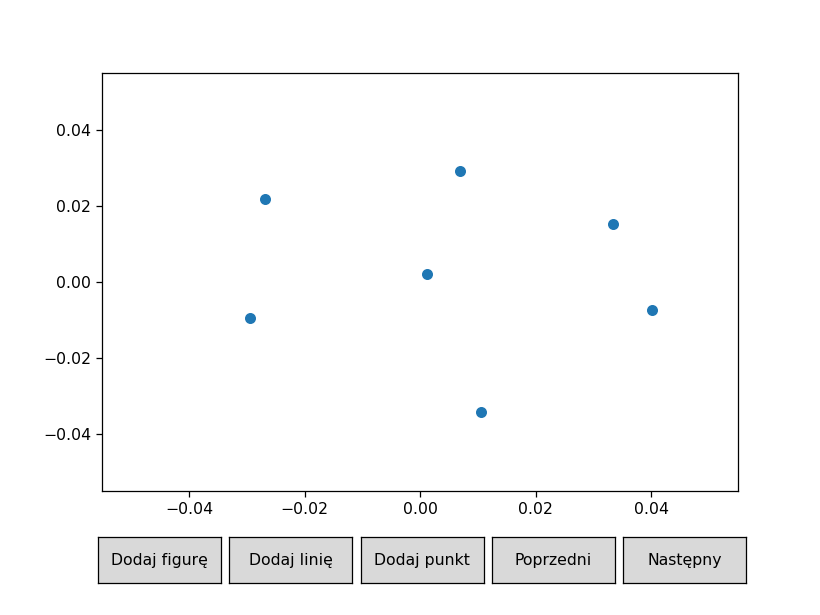

In [6]:
#miejsce do wprowadzania punktów ręcznie
#aby mieć ciągłe parabole, należy oddalić zakres wykresu używając opcji "Pan", 
#a następnie przytrzymać i przeciągnąć kursor myszy po wykresie
plot1 = Plot()
plot1.draw()

In [7]:
#wybieramy points do plotowania poniżej
#punkty generowane przez funkcje, można tutaj dopisać inne funckje generujące punkty, pojawiające się w komórce 4
points = uniformly_distributed_points(number_of_points=50)
#własnoręcznie wprowadzane punkty, należy odkomentować i zakomentować resztę
#points = np.array(plot1.get_added_points()[0].points)

<IPython.core.display.Javascript object>


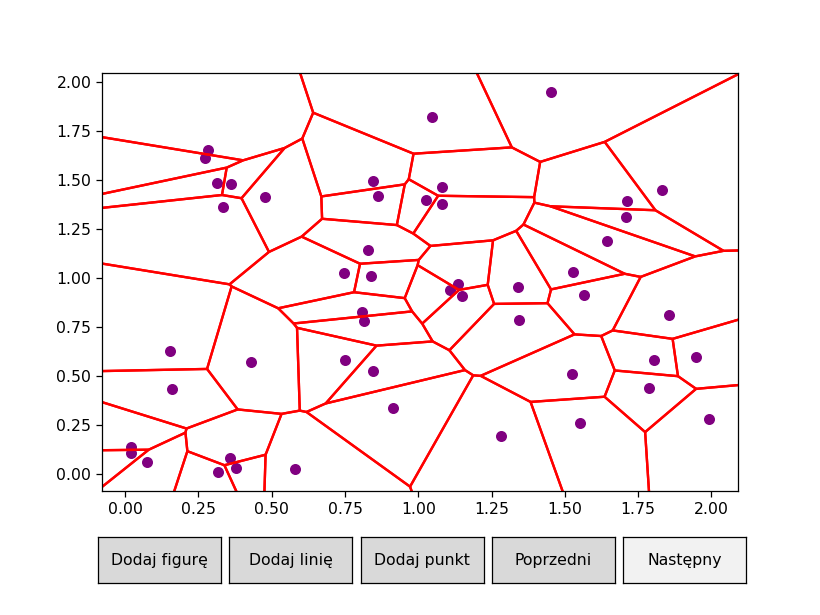

In [8]:
#generowanie diagramu Voronoi na podstawie wcześniej ustalonych punktów (Fortune algorithm)
#zamykamy ewentualnie wcześniej włączony plot, a następnie generujemy zestaw punktów z zadanego przedziału i 
#tworzymy wizualizacje działania algorytmu z wykorzystaniem narzędzia graficznego
plt.close()
fortune = FortuneAlgorithm(points, metric=euclidean_2d)
scenes = fortune.construct(points)

plot = Plot(scenes)
plot.draw()
#jeśli pojawi się błąd typu construct() takes 1 positional argument but were given 2, to należy ponownie uruchomić
#pierwszą komórkę z bibliotekami

<IPython.core.display.Javascript object>


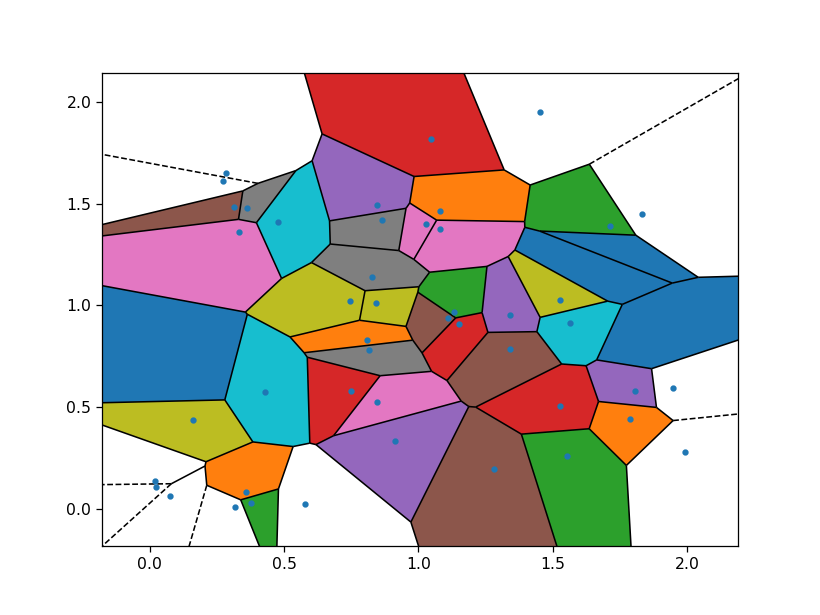

In [9]:
#funkcja generująca diagram Voronoi z modułu scipy.spatial, pokazana tylko do celów wizualizacyzjnych
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d


#funkcja Voronoi na podstawie listy punktów generuje diagram Voronoi
voronoi_diagram = Voronoi(points)

# funkcja modyfikująca obiekt stworzony przez funkcje Voronoi na obiekt który można wyświetlać
voronoi_plot_2d(voronoi_diagram, show_vertices = False)

# kolorowanie obszarów, regions przechowuje liste wierzchołków, wchodzących w skład obszarów diagramu Voronoi
# jeśli obecna jest w nim -1 to oznacza to jak mówi dokumentacja, że reprezentuje obszar nieograniczony, 
#przechowuje krawędzie oraz ustalony wierzchołek diagramu Voronoi
for region in voronoi_diagram.regions:
    if not -1 in region:
        site = [voronoi_diagram.vertices[i] for i in region]
        plt.fill(*zip(*site))
        
plt.show()

<IPython.core.display.Javascript object>


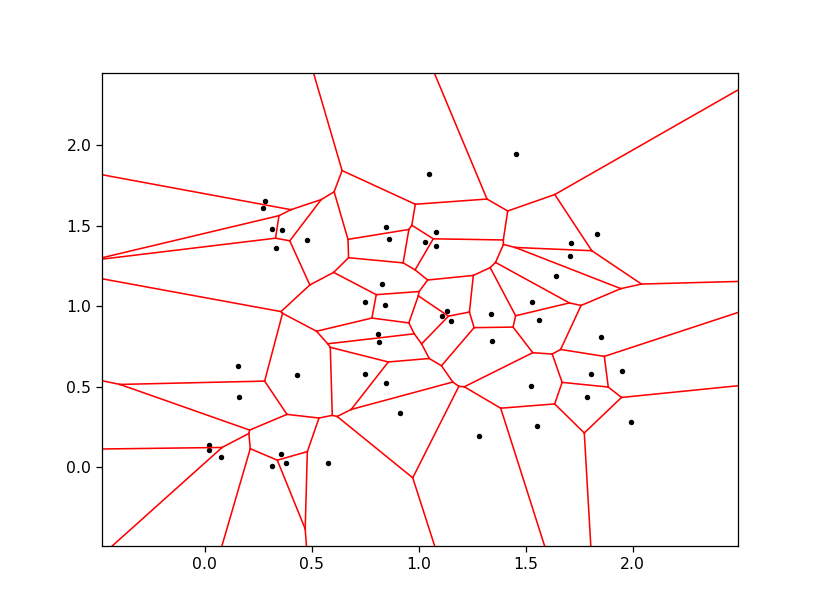

In [10]:
#generowanie diagramu Voronoi na podstawie wcześniej ustalonych punktów (z triangulacji Delaunaya)
%matplotlib notebook
plt.clf()
edges_vor = Voronoi_from_triangulation(points)
plot_voronoi_edges(edges_vor, points)

<IPython.core.display.Javascript object>


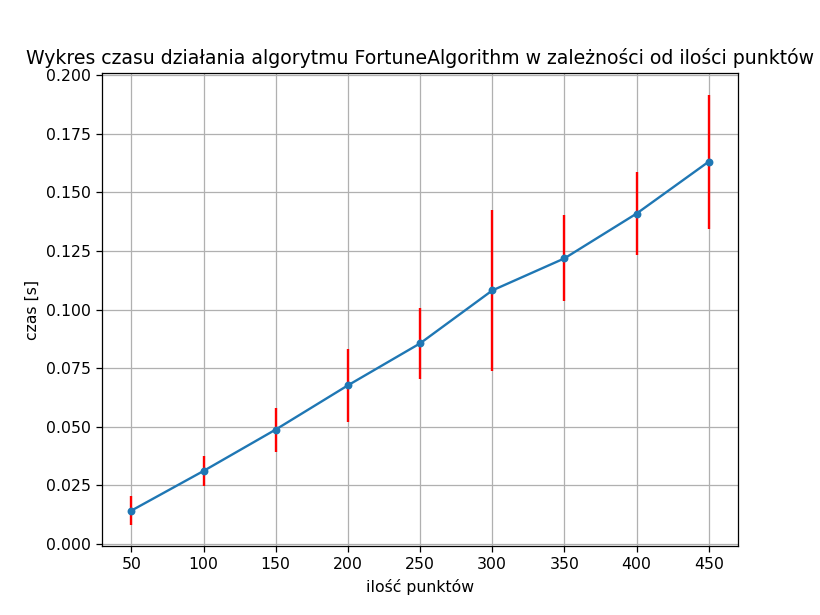

In [11]:
#tutaj mierzy się czasy działania obu algorytmów znajdowania diagramów Voronoi
#Pomiary są wykonywane w seriach dla ustalonych ilość punktów, nastepnie na wykresie są pokazywane średnie wyniki
#paski błędów na wykresie oznaczają jedno odchylenie standardowe od średniej

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
import time
from Fortune_algorithm_time import FortuneAlgorithm
%matplotlib notebook

#funkcja rysuje wykres zależności czasu działania wybranego algorytmu od ilości punktów
#funkcja przyjmuje liczbe 0, 1 lub 2
#0 oznacza, że testujemy Voronoi_from_triangulation
#1 oznacza, że testujemy Voronoi
#2 oznacza, że testujemy FortuneAlgorithm
#oprócz tego możemy ustalić dla jakich liczb punktów rysujemy wykres (num_points)
#możemy też wybrać ilość wykonanych powtórzeń pomiarów dla ustalonej liczby punktów (num_test)


def time_test_plot(which_alg, num_points  = [50, 100, 150, 200, 250, 300, 350, 400, 450], num_test = 50):
    
    if type(which_alg) != int or which_alg > 2 or which_alg < 0:
        print("niepoprawny numer, wybierz 0, 1 lub 2")
        return
    
    algorithms = [Voronoi_from_triangulation, Voronoi, FortuneAlgorithm]
    points = []
    result = []

    for i in num_points:
        points = add_n_points(points, i-len(points))
        partial_res = []
        if which_alg == 2:
            for tests in range(num_test):
                fortune = algorithms[2](points, metric=euclidean_2d)
                start = time.time()
                fortune.construct()
                end = time.time()
                partial_res.append(end - start)
        else:
            for tests in range(num_test):
                start = time.time()
                algorithms[which_alg](points)
                end = time.time()
                partial_res.append(end - start)

        mean = np.mean(partial_res)
        std = np.std(partial_res)
        result.append([mean, std])

    means, stds = list(zip(*result))

    
    plt.errorbar(num_points, means, yerr=stds, marker='o', ms=4, ecolor='red')
    plt.title("Wykres czasu działania algorytmu " + algorithms[which_alg].__name__ + " w zależności od ilości punktów",
             wrap = True)
    plt.xlabel("ilość punktów")
    plt.ylabel("czas [s]")
    plt.grid(True)
    plt.show()

time_test_plot(2)

In [12]:
#zapis do plików JSON, należy wybrać, jak generować points i odkomentować, można wybrać inne funkcje generujące punkty (komórka 4)
#points = plot1.get_added_points()[0].points
#points = uniformly_distributed_points(number_of_points=50)

with open("sample.json", "w") as outfile: 
    js.dump(points.tolist(), outfile) 


with open('sample.json', 'r') as openfile: 
  
    # Reading from json file 
    json_object = js.load(openfile)